In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

from mf_system.hardware.devices.utils import DeviceNotFoundError
from mf_system.hardware.devices.interface import IHardwareAdapter
from mf_system.hardware.devices.uv_vis_lib.uvvissdk import uvvisremotecontrol

# Types of FLEX devices
FLEX_types = ["STD", "RES+"]


class UVvisAdapter(IHardwareAdapter):
    def __init__(self, config: dict):
        self.FTHandle_ID = None
        self._connection = None
        self.int_time = config["integration_time"]
        self.average = config["average"]
        self.smoothing = config["smoothing"]

    def initialize(self):
        self._connection = uvvisremotecontrol.UVvis()
        device_info = self._connection.scan_devices()
        print(device_info)
        n_devices = device_info[0]  # Index 0 contains the number of connected devices

        if n_devices == 0:
            raise DeviceNotFoundError("No devices found!")

        device_id = device_info[1]
        print(
            f"Current device {device_id} with serial number: {self._connection.get_serial(device_id)}"
        )

        FLEX_type_n = device_info[2]

        print(f"Device type: {FLEX_types[FLEX_type_n]}")

        # Connects and gets handle to use with other functions
        self.FTHandle_ID = self._connection.connect(device_id)

        # Disable trigger in/out mode
        self._connection.trigger_in_disable(self.FTHandle_ID)
        self._connection.trigger_out_on_off(False, self.FTHandle_ID)

        if self.FTHandle_ID != -1:  # Test if the connection was successful
            self._connection.switch_LED(True, self.FTHandle_ID)  # Turn the LED on

    def execute(self, command: dict) -> str:
        action = command["action"]

        match action:
            case "change_integration_time":
                return self._connection.change_integration_time(
                    command["int_time"], self.FTHandle_ID
                )
            case "measure":
                return self.measure()
            case "switch_LED":
                return self._connection.switch_LED(command["switch"], self.FTHandle_ID)
            case "switch_shutter":
                return self._connection.switch_shutter(
                    command["switch"], self.FTHandle_ID
                )
            case _:
                raise ValueError(f"Unsupported command: {action}")

    def shutdown(self) -> None:
        if self._connection:
            self._connection.disconnect(self.FTHandle_ID)

    def measure(self):
        self._connection.change_integration_time(self.int_time, self.FTHandle_ID)

        # Get wavelenth array (list type)
        c0, c1, c2, c3 = self._connection.read_EEPROMCoeff(self.FTHandle_ID)
        wavelengths = self._connection.get_XData(c0, c1, c2, c3, self.FTHandle_ID)
        n_pixels = len(wavelengths)

        res_list = []
        for i in range(self.average):
            res_list.append(
                self._connection.get_YData(False, self.FTHandle_ID)[:n_pixels]
            )

        data = np.array(res_list)
        mean_values = np.mean(data, axis=0)
        return wavelengths, mean_values

    def get_Absorbance(self, Sn: list[float], Dn: list[float], Rn: list[float]):
        Sn, Dn, Rn = np.array(Sn), np.array(Dn), np.array(Rn)

        denominator = Rn - Dn  
        numerator = Sn - Dn 

        # Avoid division by zero or invalid log values
        with np.errstate(divide='ignore', invalid='ignore'):  
            ratio = np.where(denominator != 0, numerator / denominator, np.nan)  # Avoid division by zero
            An = -np.log10(ratio)  # Compute absorbance

        # Replace invalid values (NaN, Inf) with zeros or another fallback
        An = np.nan_to_num(An, nan=0.0, posinf=0.0, neginf=0.0)

        return An

    def get_Transmittance(self, Sn: list[float], Dn: list[float], Rn: list[float]):
        Tn = (Sn - Dn) / (Rn - Dn) * 100
        return Tn

    def plot_result(self, wavelengths, spectrum, save_path):
        plt.subplots()
        plt.plot(wavelengths, spectrum)
        plt.xlabel(r"Wavelength (nm)")
        plt.ylabel("Intensity (counts)")
        plt.xlim(wavelengths[0], wavelengths[-1])
        plt.ylim(
            np.min(spectrum) - 0.05 * (np.max(spectrum) - np.min(spectrum)),
            np.max(spectrum) + 0.05 * (np.max(spectrum) - np.min(spectrum)),
        )

        # Save the plot
        plt.savefig(save_path)
        plt.show()

[1, 1, 1]
Current device 1 with serial number: FTWN77TEA
Device type: RES+
ref finished, please dip the probe in the sample


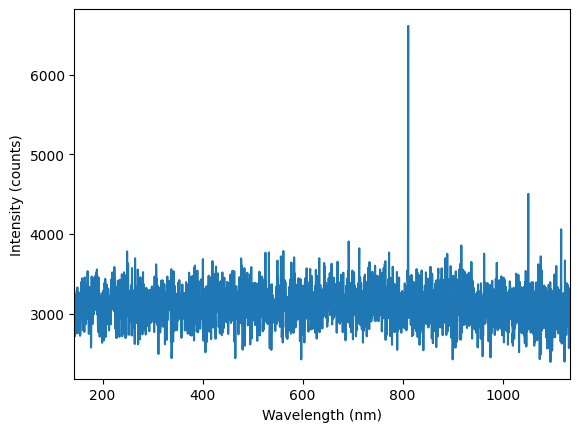

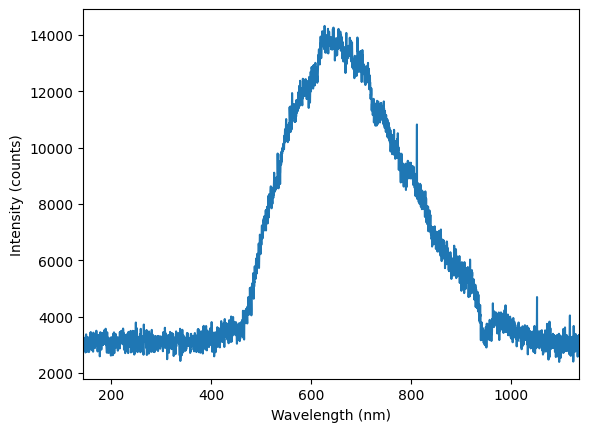

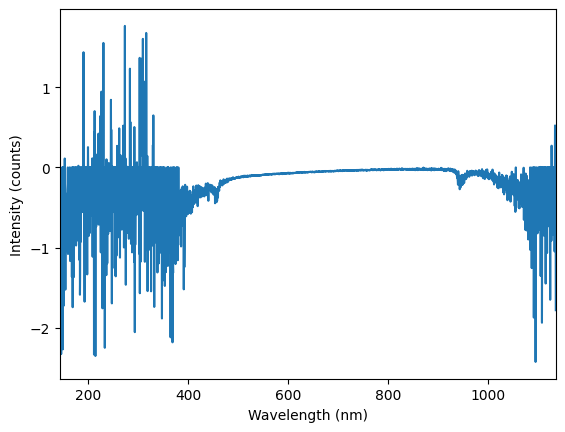

In [2]:
uvvis = UVvisAdapter({"integration_time": 1000, "average": 5, "smoothing": 11})
uvvis.initialize()
uvvis.execute({"action": "switch_shutter", "switch": True})
time.sleep(0.1)
wave_d, dark = uvvis.measure()
uvvis.execute({"action": "switch_shutter", "switch": False})
time.sleep(0.1)
wave_r, ref = uvvis.measure()
print("ref finished, please dip the probe in the sample")
time.sleep(5)

wave_s, sample = uvvis.measure()

An = uvvis.get_Absorbance(sample, dark, ref)

uvvis.plot_result(wave_d, dark, "./plot_dark.png")
uvvis.plot_result(wave_r, ref, "./plot_ref.png")
uvvis.plot_result(wave_s, An, "./plot_sample.png")
time.sleep(0.1)

uvvis.shutdown()

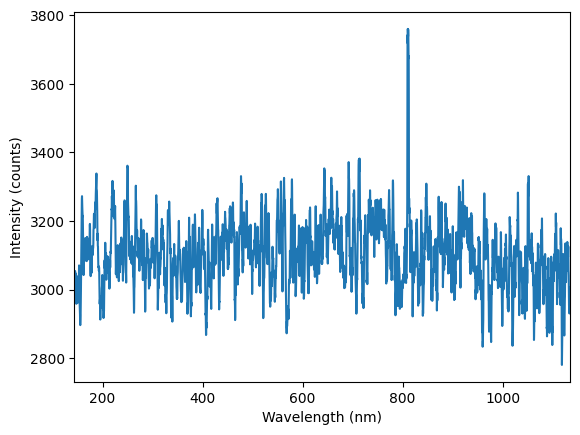

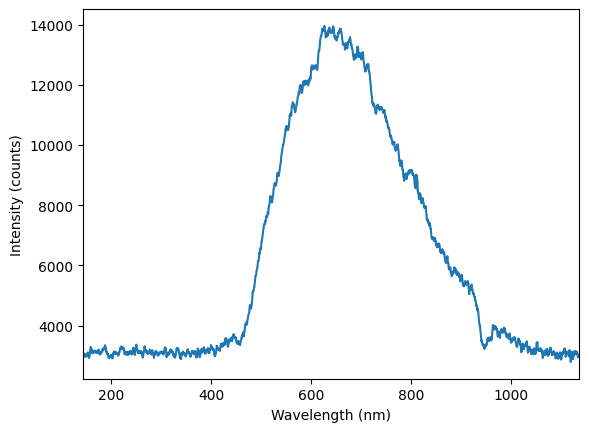

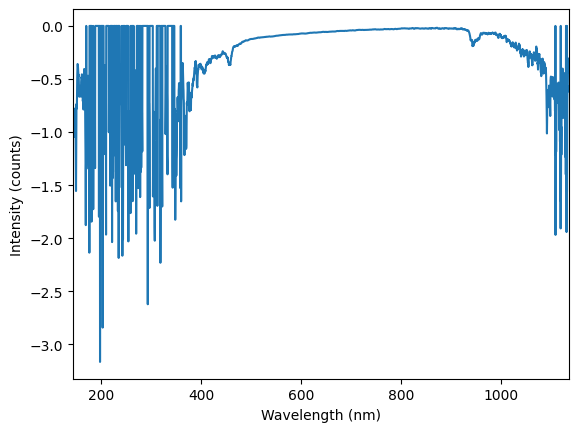

In [4]:
from mf_system.hardware.devices.utils import moving_average

dark_sm = moving_average(dark, 11)
ref_sm = moving_average(ref, 11)

sample_sm = moving_average(sample, 11)

An_sm = uvvis.get_Absorbance(sample_sm, dark_sm, ref_sm)

uvvis.plot_result(wave_d, dark_sm, "./plot_dark.png")
uvvis.plot_result(wave_r, ref_sm, "./plot_ref.png")
uvvis.plot_result(wave_s, An_sm, "./plot_sample.png")


In [7]:
print(An)
print(wave_s)
print(np.isnan(wave_s).any())
print(np.isnan(An).any())

[-1.12240207 -1.00527795 -1.11257765 ... -0.84269197 -1.65858372
 -1.21728748]
[143.691, 144.00191174929634, 144.31281299121073, 144.6237037167812, 144.93458391704579, 145.24545358304252, 145.55631270580943, 145.86716127638462, 146.1779992858061, 146.48882672511184, 146.79964358534002, 147.11044985752855, 147.42124553271555, 147.732030601939, 148.04280505623697, 148.3535688866475, 148.66432208420864, 148.9750646399584, 149.2857965449349, 149.59651779017605, 149.90722836672, 150.21792826560474, 150.52861747786832, 150.8392959945488, 151.14996380668416, 151.46062090531248, 151.77126728147186, 152.08190292620023, 152.3925278305357, 152.70314198551628, 153.01374538218, 153.32433801156495, 153.6349198647091, 153.94549093265056, 154.25605120642737, 154.5666006770775, 154.87713933563904, 155.18766717315003, 155.49818418064848, 155.80869034917245, 156.11918566976, 156.42967013344915, 156.74014373127793, 157.05060645428438, 157.36105829350657, 157.6714992399825, 157.98192928475024, 158.29234841

In [2]:
if FThandle_ID != -1:  # Test if the connection was successful

    uvvis.switch_LED(True, FThandle_ID)  # Turn the LED on

    # Change integration time to the lowest value possible
    if FLEX_type_n == 0:
        integration_time = 2
    else:
        integration_time = 3
    uvvis.change_integration_time(1000, FThandle_ID)

    # Get wavelenth array (list type)
    c0, c1, c2, c3 = uvvis.read_EEPROMCoeff(FThandle_ID)
    wavelengths = uvvis.get_XData(c0, c1, c2, c3, FThandle_ID)
    n_pixels = len(wavelengths)

    uvvis.trigger_in_disable(FThandle_ID)  # Internal trigger mode

    uvvis.trigger_out_on_off(False, FThandle_ID)  # Trigger out disabled

    # Dark measurement
    uvvis.switch_shutter(True, FThandle_ID)  # Close shutter
    time.sleep(0.1)
    # Perform a measurement
    dark = uvvis.get_YData(False, FThandle_ID)[:n_pixels]
    uvvis.switch_shutter(False, FThandle_ID)  # Open shutter
    time.sleep(0.1)

    # Internal trigger measureme
    spectrum = uvvis.get_YData(False, FThandle_ID)[:n_pixels]

print("finished")

finished


In [6]:
print(dark)
print(spectrum)
print(type(dark[0]))

[2556.0, 2375.0, 2015.0, 2312.0, 2322.0, 2310.0, 2579.0, 2480.0, 2176.0, 2311.0, 2468.0, 2182.0, 2201.0, 2367.0, 2224.0, 2070.0, 2159.0, 2240.0, 2504.0, 2860.0, 2357.0, 2082.0, 2302.0, 2241.0, 2122.0, 2363.0, 2637.0, 2382.0, 2255.0, 2268.0, 2430.0, 2483.0, 2366.0, 2279.0, 2395.0, 2157.0, 1980.0, 2016.0, 1988.0, 2070.0, 2183.0, 2188.0, 2181.0, 2284.0, 2336.0, 2494.0, 2626.0, 2486.0, 2422.0, 2641.0, 2433.0, 2602.0, 2533.0, 2597.0, 2364.0, 2153.0, 2349.0, 2481.0, 2340.0, 2279.0, 2344.0, 2343.0, 2217.0, 2174.0, 2096.0, 2399.0, 2483.0, 2327.0, 2175.0, 2129.0, 2320.0, 2405.0, 2240.0, 2321.0, 2235.0, 2180.0, 2439.0, 2405.0, 2143.0, 2657.0, 2601.0, 2192.0, 2198.0, 2286.0, 2305.0, 2709.0, 2493.0, 2222.0, 2248.0, 2225.0, 2387.0, 2573.0, 2494.0, 2200.0, 2249.0, 2374.0, 2380.0, 2398.0, 2551.0, 2681.0, 2403.0, 2471.0, 2477.0, 2293.0, 2383.0, 2328.0, 2323.0, 1981.0, 2027.0, 2298.0, 2552.0, 2786.0, 2599.0, 2412.0, 2183.0, 2284.0, 2405.0, 2199.0, 2334.0, 2384.0, 2319.0, 2429.0, 2768.0, 2698.0, 2612.0,

In [7]:
import numpy as np
data = np.array([dark, spectrum])

mean_val = np.mean(data, axis=0)
print(mean_val)

[2590.  2376.  2062.5 ... 2509.  2353.  2252.5]


In [14]:
def moving_average(data, window_size):
    """Smooth a list using a moving average."""
    if window_size < 1:
        raise ValueError("Window size must be at least 1.")

    if window_size % 2 == 0:
        raise Warning("Window size should always be a odd number.")

    kernel = np.ones(window_size) / window_size  # Create a smoothing kernel
    smoothed = np.convolve(data, kernel, mode="valid")  # Apply convolution\
    
    # Pad the result to maintain the original size
    pad_size = (window_size - 1) // 2  # Number of elements to pad on each side
    smoothed_full = np.pad(smoothed, (pad_size, pad_size), mode='edge')

    return smoothed_full

In [19]:
sm = moving_average(spectrum, 11)


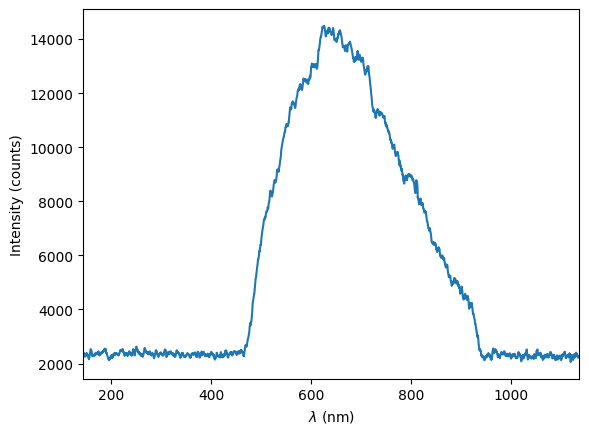

In [20]:
import matplotlib.pyplot as plt
# Plotting the spectrum
plt.subplots()
plt.plot(wavelengths, sm)
plt.xlabel(r"Wavelength (nm)")
plt.ylabel("Intensity (counts)")
plt.xlim(wavelengths[0], wavelengths[-1])
plt.ylim(
    np.min(sm)
    - 0.05 * (np.max(sm) - np.min(sm)),
    np.max(sm)
    + 0.05 * (np.max(sm) - np.min(sm)),
)
plt.show()